In [275]:
# Parse results

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
import re
from pathlib import Path

def mean(l):
    return sum(l) / len(l)

def parse_baseline_res(fpath):
    header = re.compile(r'--> Test (\S+) <--')
    time = re.compile(r'Time:\s*(.*)')
    
    with open(fpath, 'r') as f:
        lines = list(f.readlines())
        
    run_results = [lines[i::2] for i in range(2)]
    compiler = [(header, str), (time, float)]
    full_results = [[compiler[i][1](compiler[i][0].match(elems).group(1)) \
                         for elems in run_key] for i, run_key in enumerate(run_results)]
    full_results[0] = [Path(x).name.split('.')[0] for x in full_results[0]]
    baseline_dict = dict(zip(*full_results))
    print(baseline_dict)
    return baseline_dict
        

    
def parse_batch_res(lines):
    header = re.compile(r'<-- Batch: (\S+) -->')
    max_time = re.compile(r'Max Time:\s*(.*)')
    accuracy = re.compile(r'Accuracy:\s*(.*)')
    
    run_results = [lines[i::3] for i in range(3)]

    compiler = [(header, str), (max_time, float), (accuracy, float)]
    full_results = [[compiler[i][1](compiler[i][0].match(elems).group(1)) \
                         for elems in run_key] for i, run_key in enumerate(run_results)]
    
    test_names = sorted(list(set(full_results[0])))
    num_tests = len(test_names)
    
    comp_results = [full_results[0][:num_tests]] + \
                    [[mean(full_results[j][i::num_tests]) for i in range(num_tests)] for j in [1,2]]
   
    #comp_results_perc = [ [full_results[0][:num_tests]], \
    #                [mean(full_results[1][i::num_tests]) for i in range(num_tests)], \
    #                [mean(full_results[2][i::num_tests]) for i in range(num_tests)]
    #                    ]
    
    run_dict = { i[0]: i[1:] for i in zip(*comp_results) }
    return run_dict

    
    
results_dir = Path('results')

stoch_range = np.arange(10, 100, 10)
batch_range = np.arange(2, 12, 2)

dataset_paths = results_dir.glob('run_*.res')
baseline_path = results_dir / 'single_run.res'
baseline_dict = parse_baseline_res(baseline_path)
testname_size = len(baseline_dict)

complete_run_dict = {}

for stoch, batch_size in it.product(stoch_range, batch_range):
    stoch_idx = np.where(stoch_range == stoch)[0][0]
    batch_idx = np.where(batch_range == batch_size)[0][0]
    #print(stoch, batch_size)
    
    runs_content = []
    for dpath in results_dir.glob(f"run_*_{stoch}_{batch_size}.res"):
        with open(dpath) as f:
            runs_content += list(f.readlines())
    run_dict = parse_batch_res(runs_content)
    #print(run_dict)
    
    for key, res in run_dict.items():
        if key not in complete_run_dict:
            complete_run_dict[key] = np.empty([stoch_range.size, batch_range.size, 2])
        complete_run_dict[key][stoch_idx][batch_idx][:] = np.array(res)

# Overhead compute relative to baseline
for key, res in complete_run_dict.items():
    res[:,:,0] /= baseline_dict[key]


{'indirect': 0.044, 'input-dep': 0.906, 'lfq': 0.893, 'loop-antidep': 2.89, 'thread': 1.156, 'thread_lock': 0.966}


In [276]:
print(complete_run_dict['indirect'].shape)
print(complete_run_dict['indirect'][:,:,0])
print(complete_run_dict['indirect'][:,:,1])

(9, 5, 2)
[[0.21590909 0.33409091 0.36363636 0.47954545 0.46136364]
 [0.67045455 0.625      0.79545455 0.76136364 0.76363636]
 [0.79772727 1.08409091 0.93409091 0.98409091 1.04545455]
 [1.06590909 1.17045455 1.01818182 1.20227273 1.10681818]
 [1.11818182 1.34545455 1.31818182 1.28636364 1.46818182]
 [1.31363636 1.74318182 1.46590909 1.62272727 1.53636364]
 [1.46590909 1.71136364 1.775      1.69318182 1.65454545]
 [1.575      1.92272727 1.86590909 1.875      1.7       ]
 [1.79545455 2.04318182 2.00454545 2.07727273 1.95681818]]
[[  2.85714286   4.76190476   8.57142857  14.76190476  13.80952381]
 [ 20.          23.80952381  34.28571429  49.04761905  53.33333333]
 [ 35.23809524  50.          63.33333333  67.61904762  72.85714286]
 [ 44.76190476  61.9047619   72.85714286  83.80952381  86.19047619]
 [ 53.80952381  77.14285714  87.14285714  91.9047619   92.85714286]
 [ 75.23809524  88.0952381   92.85714286  98.0952381   99.04761905]
 [ 80.          97.14285714  99.52380952  99.04761905 100. 

Finished "indirect"
Finished "input-dep"
Finished "lfq"
Finished "loop-antidep"
Finished "thread"
Finished "thread_lock"


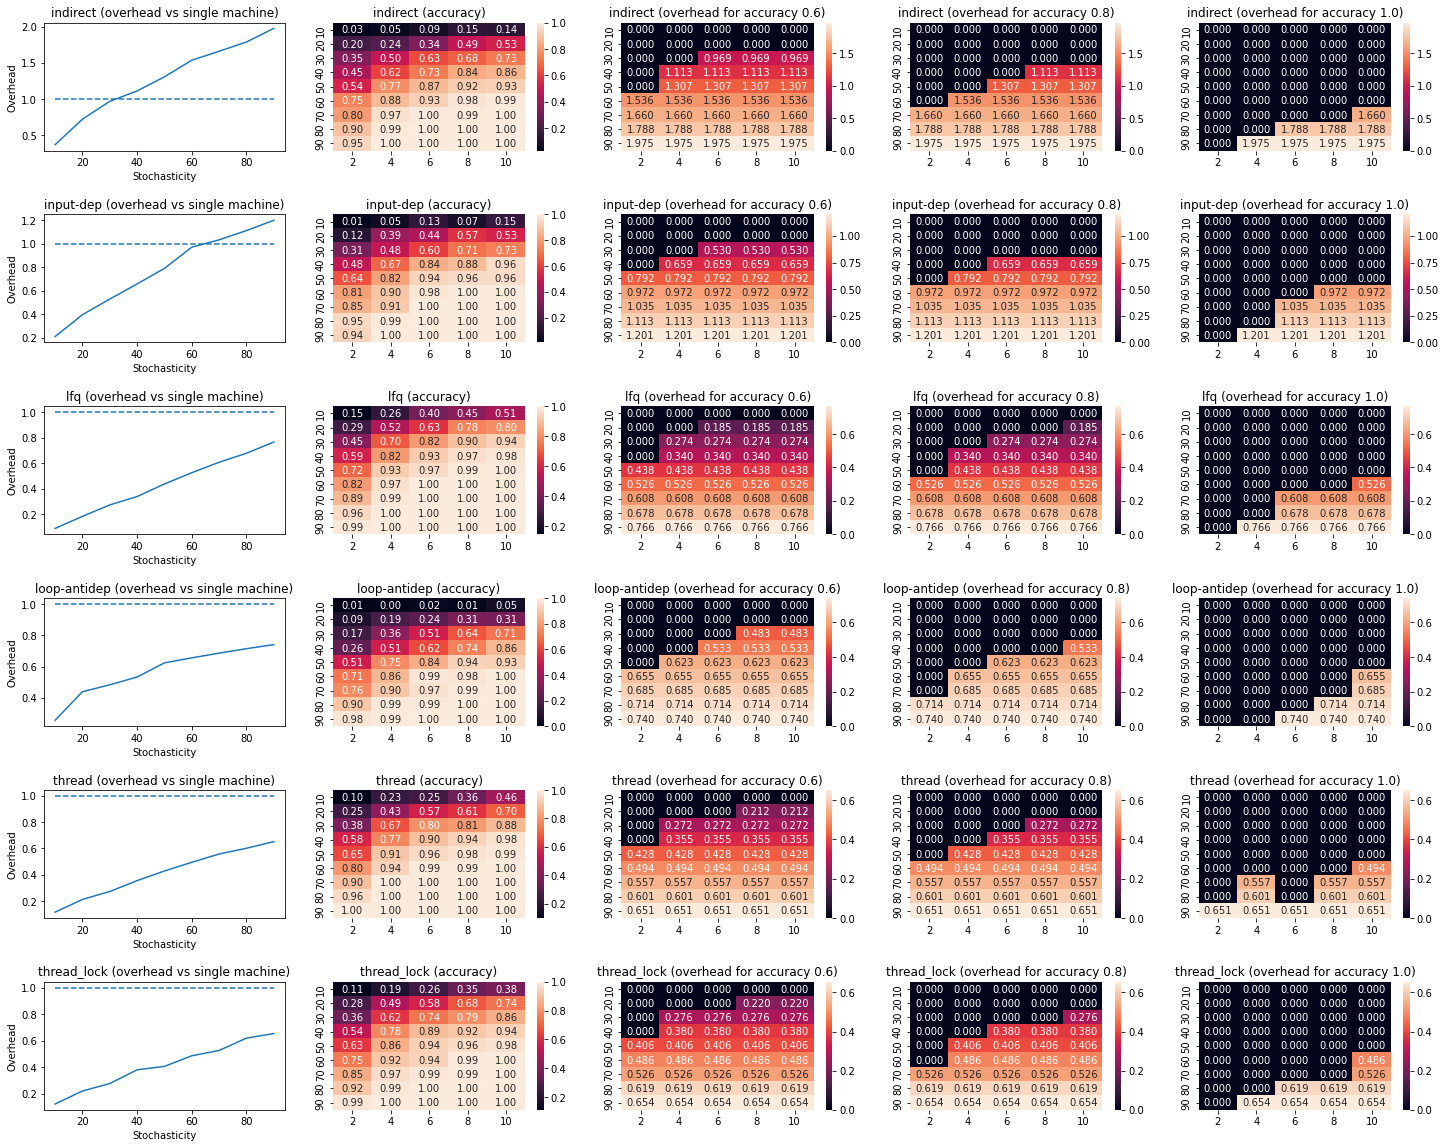

In [298]:
import matplotlib.pyplot as plt


target_accuracies = np.array([60, 80, 100]) / 100

fig, axs = plt.subplots(testname_size, 2 + target_accuracies.size, figsize=(25, 20))
plt.subplots_adjust(hspace=0.5)


testname = 'indirect'
i = 0
for testname, result in complete_run_dict.items():
    print(f"Finished \"{testname}\"")
    overhead = result[:,:,0]
    overhead_mean = np.mean(overhead, axis=1)
    axs[i][0].plot(stoch_range, overhead_mean)
    axs[i][0].hlines(y=1.0, xmin=stoch_range[0], xmax=stoch_range[-1], linestyles='dashed')
    axs[i][0].set_title(testname + ' (overhead vs single machine)')
    axs[i][0].set_xlabel('Stochasticity')
    axs[i][0].set_ylabel('Overhead')
    
    accuracy = result[:,:,1] / 100
    sns.heatmap(accuracy, annot=True, fmt='.2f',
               xticklabels=batch_range,
               yticklabels=stoch_range,
               ax=axs[i][1])
    axs[i][1].set_title(testname + ' (accuracy)')

    for j, target_accuracy in enumerate(target_accuracies):
        max_matrix = (accuracy >= target_accuracy) * np.expand_dims(overhead_mean, axis=1) + (500*(accuracy>1.0))
        #optimize_matrix = (accuracy**3) / np.expand_dims(overhead_mean, axis=1)**2
        sns.heatmap(max_matrix, annot=True, fmt='.3f',
                   xticklabels=batch_range,
                   yticklabels=stoch_range,
                   ax=axs[i][2+j])
        axs[i][2+j].set_title(testname + f" (overhead for accuracy {target_accuracy})")
    
    
    i += 1


In [294]:
fig
fig.savefig('heatmaps.jpg')

In [259]:
plt.savefig('heatmaps.png')

<Figure size 432x432 with 0 Axes>